## NITE regulation
**Identifying divergence between local chromatin accessibility and gene expression**

A general assumption made in single-cell analysis (gene scoring, data integration, etc.) is that changes in local chromatin accessibility correspond to changes in gene expression. We found that assumption is frequently violated, and that when chromatin accessibiltity diverges from gene expression this has interesting implications for regulation and signaling. The next tutorial demonstrates how to use RP modeling to quantify the divergence between modes.

First, an introduction of terms:

 - **L**ocal chromatin accessibility-**I**nfluenced **T**ranscriptional **E**xpression (**LITE**) model: learns a relationship between a gene and its local chromatin only.

 - **N**on-local chromatin accessibility-**I**nfluenced **T**ranscriptional **E**xpression (**NITE**) model: extends the LITE model to relate genome-wide changes in chromatin to gene expression via the learned accessibility topics.

Since the NITE model has an expanded scope and can learn a relationship with genome-wide changes in chromatin rather than just local changes, this model is strictly better at predicting expression than the LITE model. By comparing the predictive capacity of local (LITE) vs. genome wide (NITE) chromatin changes, one can address if transcriptional regulation of a gene is modulated through local chromatin or through some other nonlocal regulatory mechanism.

By extension, one can also see if in certain cell states gene expression is more or less determined by the local chromatin landscape.

Let’s import some packages:

In [1]:
!hostnamectl

   Static hostname: psh01com1hcom43
         Icon name: computer-server
           Chassis: server
        Machine ID: 96f6166d8c254e2e93a2d98b24996b27
           Boot ID: 455038248a704eb1958e7ea5a2b99352
  Operating System: ]8;;https://www.redhat.com/Red Hat Enterprise Linux 8.10 (Ootpa)]8;;
       CPE OS Name: cpe:/o:redhat:enterprise_linux:8::baseos
            Kernel: Linux 4.18.0-553.22.1.el8_10.x86_64
      Architecture: x86-64


In [2]:
import mira
import scanpy as sc
import anndata
import warnings
warnings.simplefilter("ignore")
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc("font", size = 12)
import seaborn as sns
mira.utils.pretty_sderr()

In [8]:
rna_adata = anndata.read_h5ad("/gpfs/Home/esm5360/MIRA/mira-datasets/ds011_rna_data_tf_tg_scores.h5ad")
atac_adata = anndata.read_h5ad("/gpfs/Home/esm5360/MIRA/mira-datasets/ds011_atac_data_tss_dist.h5ad")

ds011_atac_model = mira.topics.load_model("/gpfs/Home/esm5360/MIRA/mira-datasets/ds011_atac_model.pth")
ds011_rna_model = mira.topics.load_model("/gpfs/Home/esm5360/MIRA/mira-datasets/ds011_rna_model.pth")

INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu
INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


### Training NITE Models

The NITE model is an extension of the LITE model, but with an awareness of the genome-wide chromatin landscape. First, we need to load in some LITE models. This cell loads the LITE models trained in the previous tutorial.

In [10]:
rp_args = dict(expr_adata = rna_adata, atac_adata = atac_adata)

litemodel = mira.rp.LITE_Model.load_dir(
    expr_model = ds011_rna_model,
    accessibility_model = ds011_atac_model,
    prefix='/gpfs/Home/esm5360/MIRA/data/ds011_rpmodels/'
)
# litemodel.predict(**rp_args)

In [22]:
import numpy as np

In [56]:
rna_adata.var_names

Index(['Xkr4', 'Mrpl15', 'Lypla1', 'Tcea1', 'Atp6v1h', 'Rb1cc1',
       '4732440D04Rik', 'Pcmtd1', 'Gm26901', 'Rrs1',
       ...
       'Tmsb4x', 'Prps2', 'Msl3', 'Arhgap6', 'Hccs', 'Gm15246', 'Mid1',
       'Eif2s3y', 'Uty', 'Ddx3y'],
      dtype='object', length=10719)

In [60]:
missing_model = 0
for gene in rna_adata.var_names:
    try:
        litemodel[gene]
    except IndexError:
        missing_model += 1
print(f"Missing models for {missing_model} genes")

Missing models for 8045 genes


In [51]:
missing_genes = [i for i in list(litemodel.genes) if i not in list(rna_adata.var_names)]
print(f"Skipped {len(missing_genes)} genes with no model.")

Skipped 0 genes with no model.


In [55]:
missing_genes = [gene for gene in rna_adata.var_names if gene not in litemodel]
print(f"Skipped {len(missing_genes)} / {len(rna_adata.var_names)} genes with no model.")


Skipped 10719 / 10719 genes with no model.


In [ ]:
def compute_rp_score(row, params):
    dist_kb = row['distance_to_TSS'] / 1000  # convert bp → kb
    if row['is_upstream']:
        decay = params['distance_upstream']
        weight = params['a_upstream']
    else:
        decay = params['distance_downstream']
        weight = params['a_downstream']
    return weight * np.exp(-dist_kb / decay)

all_rp_records = []

missing_genes = 0

for gene in rna_adata.var_names:
    try:
        params = litemodel[gene].parameters_
        peaks_df = litemodel[gene].get_influential_local_peaks(atac_adata, decay_periods=5.)

        peaks_df['MIRA_LITE_RP_score'] = peaks_df.apply(lambda row: compute_rp_score(row, params), axis=1)

        df = peaks_df[["distance_to_TSS", "MIRA_LITE_RP_score"]].rename_axis("peak_id").reset_index()
        df["target_id"] = gene
        df = df[["peak_id", "target_id", "distance_to_TSS", "MIRA_LITE_RP_score"]]

        all_rp_records.append(df)

    except IndexError:
        missing_genes += 1
    except KeyError:
        print(f"Gene {gene} not found in litemodel — skipping.")
    except Exception as e:
        print(f"Error processing {gene}: {e}")

print(f"Missing models for {missing_genes}")

regulatory_potential_df = pd.concat(all_rp_records, ignore_index=True)

/gpfs/Home/esm5360/miniconda3/envs/mira-env/lib/python3.10/site-packages/mira/adata_interface/rp_model.py:315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proximal_peaks['distance_to_TSS'] = np.abs(dist)
/gpfs/Home/esm5360/miniconda3/envs/mira-env/lib/python3.10/site-packages/mira/adata_interface/rp_model.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proximal_peaks['is_upstream'] = dist <= 0
/tmp/ipykernel_2563897/2219229395.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Missing models for 8045


/gpfs/Home/esm5360/miniconda3/envs/mira-env/lib/python3.10/site-packages/mira/adata_interface/rp_model.py:315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proximal_peaks['distance_to_TSS'] = np.abs(dist)
/gpfs/Home/esm5360/miniconda3/envs/mira-env/lib/python3.10/site-packages/mira/adata_interface/rp_model.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proximal_peaks['is_upstream'] = dist <= 0
/tmp/ipykernel_2563897/2219229395.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [63]:
regulatory_potential_df

peak_id target_id  distance_to_TSS  MIRA_LITE_RP_score
0         chr1:3670380-3671189      Xkr4            713.0            0.301251
1         chr1:3671393-3672246      Xkr4            322.0            0.296817
2         chr1:4785224-4786151    Mrpl15             51.0            0.186951
3         chr1:9748025-9748893    Vcpip1             78.0            0.379391
4       chr1:10037585-10038485     Cops5             91.0            0.164599
...                        ...       ...              ...                 ...
4568  chrX:164381601-164382491     Vegfd           8669.0            0.009640
4569  chrX:164419197-164420111      Piga            132.0            0.269698
4570  chrX:166238590-166239419     Gpm6b             33.0            0.199501
4571  chrX:166440247-166441159      Ofd1              1.0            0.276382
4572  chrX:167208737-167209634    Tmsb4x            129.0            0.038433

[4573 rows x 4 columns]

In [ ]:
regulatory_potential_df.to_csv("/gpfs/Home/esm5360/MIRA/mira-datasets/ds011_peak_to_gene_lite_rp_score.csv")

In [ ]:
rna_adata.write_h5ad("/gpfs/Home/esm5360/MIRA/mira-datasets/ds011_rna_data_lite_pred.h5ad")
atac_adata.write_h5ad("/gpfs/Home/esm5360/MIRA/mira-datasets/ds011_atac_data_lite_pred.h5ad")

Then, we can use the `spawn_NITE_model` function to initialize a NITE model object. The spawn function seeds the parameters of the NITE model with the pretrained values from the LITE model, and sets up the NITE model to reference the same topic models and genes.

In [6]:
nitemodel = litemodel.spawn_NITE_model()

Now we can fit the NITE model parameters. The API for the NITE model is identical to the LITE model. The code below fits the parameters, then predicts gene expression given the genome-wide chromatin state.

In [ ]:
nitemodel.fit(**rp_args, n_workers=12)

In [8]:
nitemodel.save("/gpfs/Home/esm5360/MIRA/data/ds011_rpmodels/")

Loading the model

In [65]:
from mira.rp_model import NITE_Model

rp_args = dict(expr_adata = rna_adata, atac_adata = atac_adata)
nitemodel = NITE_Model.load_dir(
    expr_model = ds011_rna_model,
    accessibility_model = ds011_atac_model,
    prefix='/gpfs/Home/esm5360/MIRA/data/ds011_rpmodels/'
    )

In [7]:
nitemodel.predict(**rp_args)

Predicting expression:   0%|          | 0/2674 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added layer: NITE_prediction
INFO:mira.adata_interface.core:Added layer: NITE_logp


In [ ]:
rna_adata.write_h5ad("/gpfs/Home/esm5360/MIRA/mira-datasets/ds011_rna_data_nite_pred.h5ad")
atac_adata.write_h5ad("/gpfs/Home/esm5360/MIRA/mira-datasets/ds011_atac_data_nite_pred.h5ad")

In [11]:
nitemodel.save("/gpfs/Home/esm5360/MIRA/data/ds011_rpmodels/")

### Chromatin differential

We define chromatin differential as the log-ratio of the LITE model prediction vs. the NITE model prediction of gene expression. When these two models predict similar values, chromatin differential is close to zero. If the LITE model over-estimates expression (say in the case of lineage priming) then chromatin differential increases. In the plots below, over-estimation is indicated in Red. First, calculate chromatin differential:

In [9]:
mira.tl.get_chromatin_differential(rna_adata)

INFO:mira.adata_interface.core:Added layer: chromatin_differential


Now plot using `mira.pl.plot_chromatin_differential`. For each gene, the expression and local chromatin/LITE prediction are shown. Then, chromatin differential is shown with Red indicating the LITE model **over-estimates** expession compared to the all-seeing NITE model. The chromatin differential color range is the same for each gene, so we can compare the magnitude across genes.

Finally, we plot the NITE vs. LITE predictions in a scatterplot, colored by observed expression counts. This final plot is most insteresting, and visually represents the predictive capacity of the LITE and NITE models. A simple way to read this plot is to imagine it is expression (NITE prediction) as a function of local chromatin accessibility (LITE prediction).

We can compare the LITE or NITE prediction against the gradient of observed expression to assess the goodness of fit. If most of the points are on the diagonal, then both models agree on expression rate.

Conversely, when cells jut off the diagonal, there is disagreement between LITE and NITE models. For **KRT23** (bottom), there is a group of cells where the LITE model suggests a medium-high expression rate, but the NITE model correctly assess these cells as having low KRT expression. These cells are colored dark red on the adjacent plot.

In [10]:
rna_adata.write_h5ad("/gpfs/Home/esm5360/MIRA/mira-datasets/ds011_rna_data_chrom_diff.h5ad")

In [68]:
import pandas as pd
import mira
import anndata
rna_adata = anndata.read_h5ad("/gpfs/Home/esm5360/MIRA/mira-datasets/ds011_rna_data_chrom_diff.h5ad")

gene_cell_chromatin_diff = pd.DataFrame(rna_adata.layers["chromatin_differential"].toarray().T, columns=rna_adata.obs_names, index=rna_adata.var_names)
gene_cell_chromatin_diff.to_csv("/gpfs/Home/esm5360/MIRA/mira-datasets/ds011_chromatin_differential.csv")

In [ ]:
gene_cell_chromatin_diff


AAACCAACATAATCCG-1  AAACCGAAGTCATCCC-1  AAACCGCGTTAACACG-1  \
Xkr4               0.040302           -0.237797           -0.502772   
Mrpl15             0.114830            0.039510           -0.054365   
Lypla1             0.000000            0.000000            0.000000   
Tcea1              0.000000            0.000000            0.000000   
Atp6v1h            0.000000            0.000000            0.000000   
...                     ...                 ...                 ...   
Gm15246            0.000000            0.000000            0.000000   
Mid1               0.000000            0.000000            0.000000   
Eif2s3y            0.000000            0.000000            0.000000   
Uty                0.000000            0.000000            0.000000   
Ddx3y              0.000000            0.000000            0.000000   

         AAACCGCGTTGAGCCG-1  AAACGGATCAGGGCCT-1  AAACGGATCATGCGTG-1  \
Xkr4              -0.281039           -0.520283           -0.504127   
Mrpl15             0.025814           -0.061928           -0.054879   
Lypla1             0.000000            0.000000            0.000000   
Tcea1              0.000000            0.000000            0.000000   
Atp6v1h            0.000000            0.000000            0.000000   
...                     ...                 ...                 ...   
Gm15246            0.000000            0.000000            0.000000   
Mid1               0.000000            0.000000            0.000000   
Eif2s3y            0.000000            0.000000            0.000000   
Uty                0.000000            0.000000            0.000000   
Ddx3y              0.000000            0.000000            0.000000   

         AAAGCTTGTAACAGGG-1  AAAGGACGTGGACCTG-1  AAAGGACGTTGTAAAC-1  \
Xkr4              -0.407721           -0.523381           -0.265082   
Mrpl15            -0.017364           -0.063204            0.030907   
Lypla1             0.000000            0.000000            0.000000   
Tcea1              0.000000            0.000000            0.000000   
Atp6v1h            0.000000            0.000000            0.000000   
...                     ...                 ...                 ...   
Gm15246            0.000000            0.000000            0.000000   
Mid1               0.000000            0.000000            0.000000   
Eif2s3y            0.000000            0.000000            0.000000   
Uty                0.000000            0.000000            0.000000   
Ddx3y              0.000000            0.000000            0.000000   

         AAAGGACGTTGTCATC-1  ...  TTTACGCGTTGCAATG-1  TTTAGGATCAGTGAAG-1  \
Xkr4               0.213975  ...           -0.374770           -0.503161   
Mrpl15             0.148050  ...           -0.005537           -0.054650   
Lypla1             0.000000  ...            0.000000            0.000000   
Tcea1              0.000000  ...            0.000000            0.000000   
Atp6v1h            0.000000  ...            0.000000            0.000000   
...                     ...  ...                 ...                 ...   
Gm15246            0.000000  ...            0.000000            0.000000   
Mid1               0.000000  ...            0.000000            0.000000   
Eif2s3y            0.000000  ...            0.000000            0.000000   
Uty                0.000000  ...            0.000000            0.000000   
Ddx3y              0.000000  ...            0.000000            0.000000   

         TTTAGGATCGGCCATA-1  TTTCCACCATAGCTGC-1  TTTCCTGAGCGCATTG-1  \
Xkr4               3.962340            0.094008            0.265537   
Mrpl15            -0.192177            0.127444            0.154276   
Lypla1             0.000000            0.000000            0.000000   
Tcea1              0.000000            0.000000            0.000000   
Atp6v1h            0.000000            0.000000            0.000000   
...                     ...                 ...                 ...   
Gm15246            0.000000            0

In [ ]:
avg_chrom_diff = gene_cell_chromatin_diff.mean(axis=1)

Xkr4       0.445032
Mrpl15     0.000094
Lypla1     0.000000
Tcea1      0.000000
Atp6v1h    0.000000
             ...   
Gm15246    0.000000
Mid1       0.000000
Eif2s3y    0.000000
Uty        0.000000
Ddx3y      0.000000
Length: 10719, dtype: float32

In [81]:
regulatory_potential_df["avg_chromatin_differential"] = regulatory_potential_df["target_id"].map(avg_chrom_diff)

In [82]:
regulatory_potential_df.to_csv("/gpfs/Home/esm5360/MIRA/mira-datasets/ds011_peak_to_gene_lite_rp_score_chrom_diff.csv")

In [ ]:

lite_pred_df = pd.DataFrame(rna_adata.layers["LITE_prediction"].toarray().T, columns=rna_adata.obs_names, index=rna_adata.var_names)
lite_pred_df.to_csv("/gpfs/Home/esm5360/MIRA/mira-datasets/ds011_lite_predictions.csv")

In [66]:
nite_pred_df = pd.DataFrame(rna_adata.layers["NITE_prediction"].toarray().T, columns=rna_adata.obs_names, index=rna_adata.var_names)
nite_pred_df.to_csv("/gpfs/Home/esm5360/MIRA/mira-datasets/ds011_nite_predictions.csv")
nite_pred_df

KeyError: 'NITE_prediction'

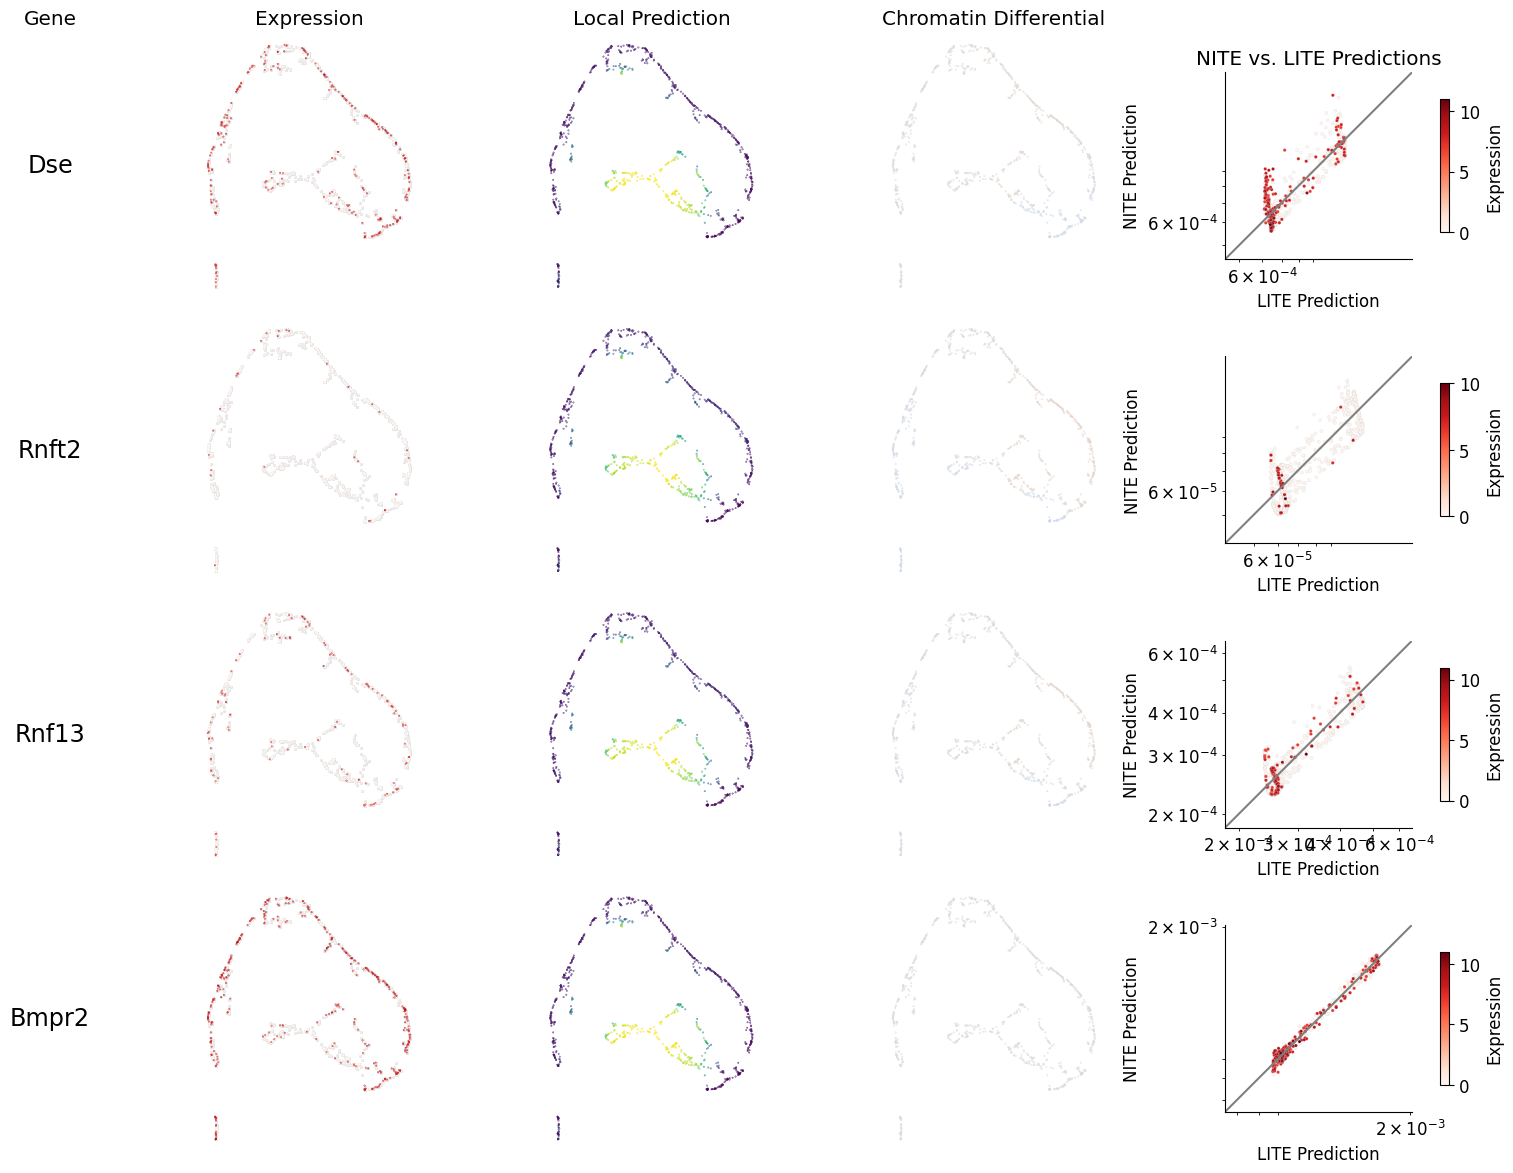

In [16]:
mira.pl.plot_chromatin_differential(rna_adata, genes = litemodel.genes[0:4],
                                    show_legend=False, size = 0.1, aspect=1.2)
plt.show()